In [24]:
from pathlib import Path
from joblib import dump, load
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, recall_score, confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc
from catboost import CatBoostClassifier, Pool

import gzip
import shutil
import os

import warnings
warnings.filterwarnings('ignore')

In [6]:
# Directory to train, validation and test datasets
path_processed_data = Path.cwd().parent / 'clean_data'

# Path to train data sets
X_train_path = path_processed_data / 'X_train.pkl'
y_train_path = path_processed_data / 'y_train.pkl'
# Path to validation data sets
X_val_path = path_processed_data / 'X_val.pkl'
y_val_path = path_processed_data / 'y_val.pkl'

# Load the datasets
X_train = load(X_train_path)
y_train = load(y_train_path)
X_val = load(X_val_path)
y_val = load(y_val_path)

#### Train CatBoost model

To handle the class imbalance in CatBoost, we can use the `class_weights` or `scale_pos_weight` parameter. Since our positive class (`is_customer` = 1) comprises **23.4%** of the dataset, the weights need to account for this imbalance.

Here’s how we can set up and train the CatBoost model:

Key Steps:
1. **Class Weights Calculation**: CatBoost recommends using weights inversely proportional to the class frequencies:

    Class weight for 0 (negative) = 1 / negative class frequency = 1 / (1−0.234) ≈ 1.30
    Class weight for 1 (positive) = 1 / positive class frequency = 1 / 0.234 ≈ 4.27

2. **Alternative**: `scale_pos_weight`: If we prefer, we can use the `scale_pos_weight` parameter, which focuses on the ratio of negative to positive class frequencies:

    scale_pos_weight = negative class frequency / positive class frequency = (1 − 0.234) / 0.234 ≈ 3.27

3. **Training the CatBoost Model**: Use either class_weights or scale_pos_weight, but not both simultaneously.

In [7]:
def filter_categorical_numeric_columns(df: pd.DataFrame) -> tuple[list[str], list[str]]:
    """
    Filters and separates categorical (object/category) and numeric columns from a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        tuple[list[str], list[str]]: 
            A tuple containing:
            - A list of categorical column names.
            - A list of numeric column names.
    """
    # Select categorical columns (object or category dtype)
    categorical_columns = df.select_dtypes(include=["object", "category"]).columns.tolist()
    
    # Select numeric columns (number dtype)
    numeric_columns = df.select_dtypes(include=["number"]).columns.tolist()
    
    return categorical_columns, numeric_columns

In [8]:
cat_features, num_features = filter_categorical_numeric_columns(df=X_train)
cat_features

['IDPROFILE',
 'PLATFORM',
 'INSTALL_SOURCE',
 'IP_COUNTRY',
 'IP_REGION',
 'BRAND',
 'SEARCH_AVG_LOS',
 'SEARCH_AVG_PAX_BINNED']

Default Parameters in `CatBoostClassifier`:
1. `iterations`:
    * Default: `1000`
    * The number of boosting iterations (trees). More iterations generally improve performance but can lead to overfitting.
2. `learning_rate`:
    * Default: `0.03`
    * The step size at each iteration while moving toward a minimum of a loss function. Smaller values often improve performance, but it requires more iterations.
3. `depth`:
    * Default: `6`
    * The depth of the trees (the maximum number of splits on a single tree). Deeper trees can model more complex relationships but may lead to overfitting.
4. `eval_metric`:
    * Default: `'Logloss'`
    * The metric used for evaluating the model during training. Logloss is a common choice for binary classification. Other metrics `'AUC'` or `'F1'`
5. `l2_leaf_reg`:
    * Default: `3`
    * L2 regularization term on leaf weights. It helps to prevent overfitting by controlling the complexity of the model.
6. `border_count`:
    * Default: `254`
    * The number of splits for each feature. Controls the granularity of feature discretization.
7. `thread_count`:
    * Default: `-1`
    * The number of threads to use during training. -1 means using all available cores.
8. `early_stopping_rounds`:
    * Default: `None`
    * Stops training if the evaluation metric doesn't improve for a set number of rounds. No early stopping by default.
9. `grow_policy`:
    * Default: `'SymmetricTree'`
    * Defines the tree growing policy. 'SymmetricTree' ensures balanced trees, while 'Depthwise' and 'Lossguide' can be used for unbalanced or faster tree growth.
10. `cat_features`:
    * Default: `None`
    * Should be specified during .fit() to indicate which columns are categorical.
11. `max_ctr_complexity`:
    * Default: `4`
    * Controls the complexity of the categorical feature encoding. It’s used when calculating combinations of categorical features.
12. `task_type`:
    * Default: `'CPU'`
    * Specifies the hardware to use for training. We can set it to 'GPU' for GPU acceleration (if supported).
13. `verbose`:
    * Default: `True`
    * Whether or not to display training progress. If True, the training progress will be printed.
14. `scale_pos_weight`:
    * Default: `None`
    * This parameter adjusts the weight of the positive class when dealing with imbalanced classes.
15. `max_depth`:
    * Default: `6`
    * Max depth of trees.

In [9]:
# Calculate scale_pos_weight
scale_pos_weight = (1 - 0.234) / 0.234  # ~3.27

# Initialize CatBoostClassifier
cat_model = CatBoostClassifier(
    scale_pos_weight=scale_pos_weight,  # Apply scale pos weights
    random_seed=64,  # For reproducibility
    iterations=1200,  # Number of boosting iterations
    learning_rate=0.2,  # Learning rate
    depth=6,  # Depth of the tree
    eval_metric='Logloss',  # Metric to optimize
    early_stopping_rounds=50,
    verbose=True  # Display progress
)

In [10]:
cat_model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),  # Validation set for evaluation
        cat_features=cat_features,  # Specify categorical columns
        use_best_model=True  # Enable early stopping
    )

0:	learn: 0.5762932	test: 0.5759266	best: 0.5759266 (0)	total: 664ms	remaining: 13m 15s
1:	learn: 0.5128983	test: 0.5122491	best: 0.5122491 (1)	total: 1.19s	remaining: 11m 51s
2:	learn: 0.4711019	test: 0.4702758	best: 0.4702758 (2)	total: 1.73s	remaining: 11m 30s
3:	learn: 0.4452842	test: 0.4442773	best: 0.4442773 (3)	total: 2.24s	remaining: 11m 9s
4:	learn: 0.4291860	test: 0.4278904	best: 0.4278904 (4)	total: 2.72s	remaining: 10m 49s
5:	learn: 0.4178113	test: 0.4165021	best: 0.4165021 (5)	total: 3.19s	remaining: 10m 33s
6:	learn: 0.4094488	test: 0.4079161	best: 0.4079161 (6)	total: 3.66s	remaining: 10m 23s
7:	learn: 0.4038437	test: 0.4022327	best: 0.4022327 (7)	total: 4.16s	remaining: 10m 19s
8:	learn: 0.3967398	test: 0.3949721	best: 0.3949721 (8)	total: 4.67s	remaining: 10m 18s
9:	learn: 0.3924841	test: 0.3905417	best: 0.3905417 (9)	total: 5.18s	remaining: 10m 16s
10:	learn: 0.3892345	test: 0.3872632	best: 0.3872632 (10)	total: 5.65s	remaining: 10m 10s
11:	learn: 0.3865580	test: 0.38

#### Evaluate classification model on the Validation Data Set

In [11]:
# If needed we can change below the default probability from 0.50 to whatever makes more sense for the business
cat_model.set_probability_threshold(binclass_probability_threshold=None)

# Generate predicted probabilities for the validation set (needed for ROC and AUC)
y_pred_prob = cat_model.predict_proba(X_val)[:, 1]  # Get probability for the positive class (1)

# Generate hard predictions (used for accuracy, recall, precision, and f1_score)
y_pred = cat_model.predict(X_val)

# Compute evaluation metrics
accuracy = round(accuracy_score(y_val, y_pred), 4)
recall = round(recall_score(y_val, y_pred), 4)
precision = round(precision_score(y_val, y_pred), 4)
f1 = round(f1_score(y_val, y_pred), 4)
roc_auc = round(roc_auc_score(y_val, y_pred_prob), 4)

# Compute ROC curve (FPR, TPR, thresholds)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Prepare the results in a dataframe
model_names = ['CatBoost_Model']
result = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'ROC_AUC': [roc_auc],
}, index=model_names)

# print results
result

,Accuracy,Precision,Recall,F1 Score,ROC_AUC
CatBoost_Model,0.8467,0.6242,0.8691,0.7266,0.931


**1. Accuracy**
   * **What it is**: The proportion of correct predictions (both `1` and `0`) out of all predictions.
   * **Formula**:<br> 
   Accuracy = (TP+TN) / Total Predictions
   * **Example**: If 100 users are predicted, and 90 are correct (e.g., 80 `0`s and 10 `1`s), accuracy is <br>
   (80+10) /100 = 90%
   * **When it's misleading**: In imbalanced datasets, accuracy can be high by predicting mostly the majority class (`0`), even if it performs poorly on the minority class (`1`).

**2. Precision**
   * **What it is**: Out of all the users predicted as customers (`1`), how many are actually customers?
   * **Formula**:  
   Precision = TP / (TP + FP)
   * **Example**: If 50 users are predicted as `1` and 30 are correct, precision is  
   30 / 50 = 60%
   * **Why it matters**: High precision means fewer false positives, important if targeting non-customers wastes resources.

**3. Recall (Sensitivity or True Positive Rate)**
   * **What it is**: Out of all actual customers (`1`), how many did the model correctly predict as customers?
   * **Formula**:  
   Recall = TP / (TP + FN)
   * **Example**: If there are 100 actual customers and the model correctly predicts 70, recall is  
   70 / 100 = 70%
   * **Why it matters**: High recall ensures most true customers are identified, useful when missing a customer is costly.

**4. F1 Score**
   * **What it is**: The harmonic mean of precision and recall, balancing both metrics.
   * **Formula**:  
   F1 = 2 * (Precision * Recall) / (Precision + Recall)
   * **Example**: If precision is 60% and recall is 70%,  
   F1 = 2 * (0.6 * 0.7) / (0.6 + 0.7) = 64.6%
   * **Why it matters**: Useful when you need a balance between precision and recall.

**5. ROC AUC (Receiver Operating Characteristic Area Under Curve)**
   * **What it is**: Measures the model's ability to distinguish between `1` and `0` across different probability thresholds (we use 0.5 probability threshold by default).
   * **How it works**: Plots the true positive rate (recall) against the false positive rate at various thresholds.
   * **Value range**: AUC is between 0 and 1. Higher AUC means better separation.
   * **Why it matters**: It evaluates the model's ranking ability, unaffected by class imbalance.

**6. ROC Curve**
   * **What it is**: A graph showing the trade-off between true positive rate (recall) and false positive rate as the decision threshold changes.
   * **Example**: If the curve is closer to the top-left corner, the model is better.
   * **Why it matters**: Useful for comparing models.

**7. AUC (Area Under Curve)**
   * **What it is**: The numerical value of the area under the ROC curve, summarizing the model's performance across thresholds.
   * **Example**: A perfect classifier has an AUC of 1, while a random guess has 0.5.
   * **Why it matters**: It’s a single number summarizing ROC performance.

**8. Confusion Matrix**
   * **What it is**: A table that shows the counts of:
     - True Positives (TP): Predicted `1` and actual `1`.
     - True Negatives (TN): Predicted `0` and actual `0`.
     - False Positives (FP): Predicted `1` but actual `0`.
     - False Negatives (FN): Predicted `0` but actual `1`.

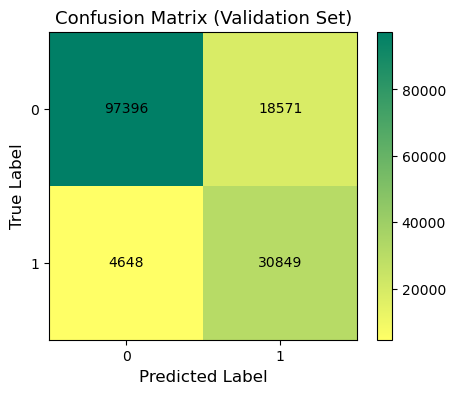

In [12]:
# Generate predicted probabilities for the validation set
y_pred_prob = cat_model.predict_proba(X_val)[:, 1]  # Get the probability of the positive class (1)

# Generate predictions on the validation set
y_pred = cat_model.predict(X_val)

# Calculate the confusion matrix
cat_confusion_matrix = confusion_matrix(y_val, y_pred)

# Plot confusion matrix with Matplotlib
plt.figure(figsize=(5, 4))
plt.imshow(cat_confusion_matrix, interpolation='nearest', cmap='summer_r')
plt.colorbar()

# Add labels
plt.xticks([0, 1], ["0", "1"])
plt.yticks([0, 1], ["0", "1"])

# Add annotations
for i in range(cat_confusion_matrix.shape[0]):
    for j in range(cat_confusion_matrix.shape[1]):
        plt.text(j, i, cat_confusion_matrix[i, j], ha='center', va='center', color='black')

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix (Validation Set)", fontsize=13)
plt.show()

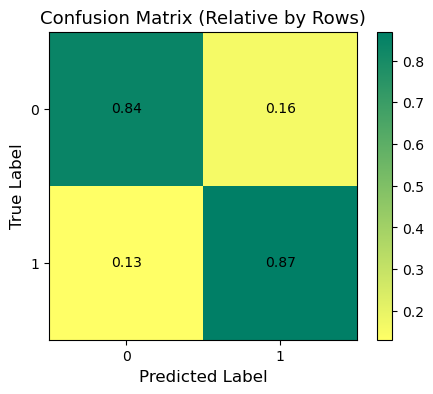

In [13]:
# Convert to relative values by rows (per true class)
cat_confusion_matrix_relative = cat_confusion_matrix.astype('float') / cat_confusion_matrix.sum(axis=1)[:, np.newaxis]

# Plot the matrix as before
plt.figure(figsize=(5, 4))
plt.imshow(cat_confusion_matrix_relative, interpolation='nearest', cmap='summer_r')
plt.colorbar()

# Add labels and annotations
for i in range(cat_confusion_matrix_relative.shape[0]):
    for j in range(cat_confusion_matrix_relative.shape[1]):
        plt.text(j, i, f"{cat_confusion_matrix_relative[i, j]:.2f}", ha='center', va='center', color='black')

# Set x and y axis labels
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix (Relative by Rows)", fontsize=13)

# Set y-ticks to show only [0, 1]
plt.xticks([0, 1], ["0", "1"])
plt.yticks([0, 1], ["0", "1"])

# Show the plot
plt.show()

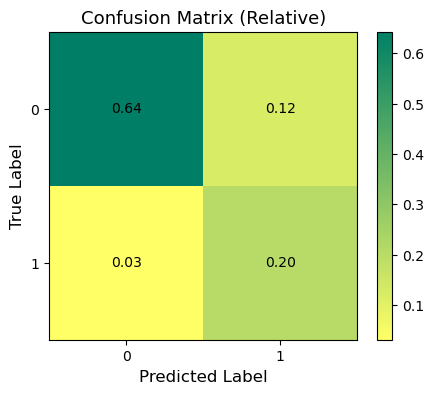

In [14]:
# Calculate the confusion matrix
cat_confusion_matrix = confusion_matrix(y_val, y_pred)

# Convert to relative values by dividing by the total number of samples
cat_confusion_matrix_relative = cat_confusion_matrix.astype('float') / cat_confusion_matrix.sum()

# Plot confusion matrix with Matplotlib
plt.figure(figsize=(5, 4))
plt.imshow(cat_confusion_matrix_relative, interpolation='nearest', cmap='summer_r')
plt.colorbar()

# Add labels
plt.xticks([0, 1], ["0", "1"])
plt.yticks([0, 1], ["0", "1"])

# Add annotations
for i in range(cat_confusion_matrix_relative.shape[0]):
    for j in range(cat_confusion_matrix_relative.shape[1]):
        plt.text(j, i, f"{cat_confusion_matrix_relative[i, j]:.2f}", ha='center', va='center', color='black')

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix (Relative)", fontsize=13)
plt.show()


In [15]:
print(classification_report(y_val, y_pred, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89    115967
           1       0.62      0.87      0.73     35497

    accuracy                           0.85    151464
   macro avg       0.79      0.85      0.81    151464
weighted avg       0.88      0.85      0.85    151464



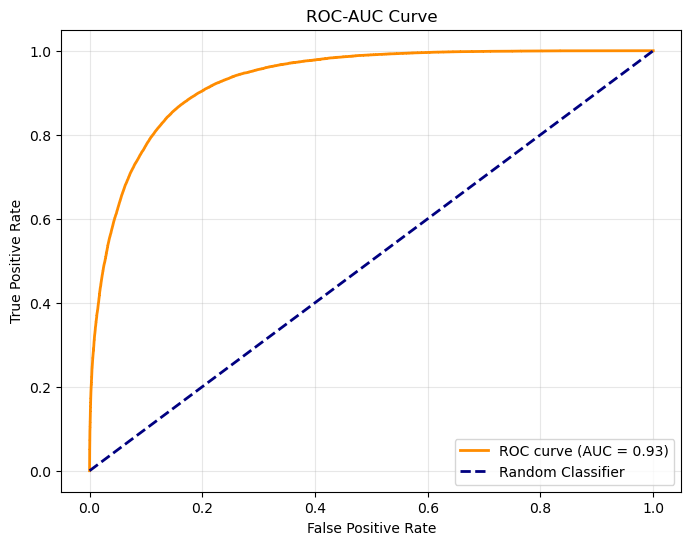

In [16]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

* `True Positive Rate` (TPR) focuses on how well the model captures true positives (actual customers), whereas
* `False Positive Rate` (FPR) focuses on how many false alarms (non-customers predicted as customers) the model generates.

Both metrics are often used together to evaluate a model, and they are important when plotting the `ROC curve` and calculating the `AUC`. <br>The goal is usually to maximize the `TPR` while minimizing the `FPR`.

#### Get CatBoost model Feature Importance

In [17]:
# Get features importance score and present the results in a dataframe
pool = Pool(X_train, y_train, cat_features=cat_features)

feature_importance = pd.DataFrame({'feature_importance': cat_model.get_feature_importance(pool),
                                   'feature_names': X_train.columns}).sort_values(by=['feature_importance'],
                                   ascending=False)

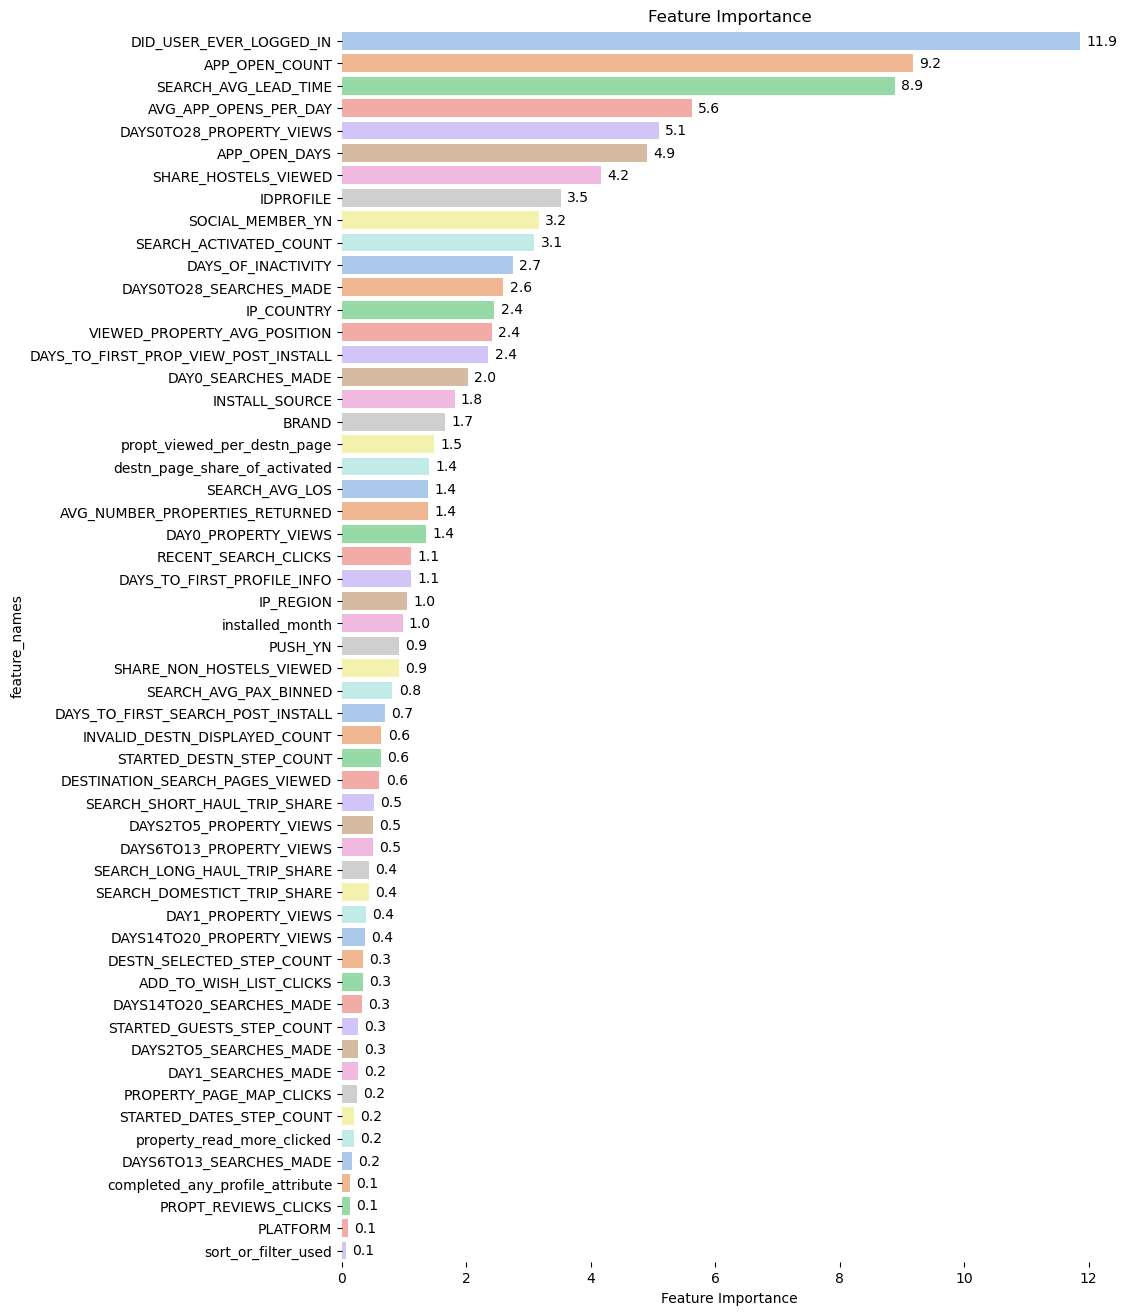

In [23]:
# Plot feature importance with labels
plt.figure(figsize=(10, 16))
ax = sns.barplot(
    x=feature_importance['feature_importance'], 
    y=feature_importance['feature_names'], 
    palette='pastel'
)

# Add labels at the end of the bars
for i, (value, name) in enumerate(zip(feature_importance['feature_importance'], 
                                      feature_importance['feature_names'])):
    ax.text(value + 0.1, i, f'{value:.1f}', va='center')  # Add a small offset to avoid overlap

# Remove border
plt.box(False)

plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.show()

#### Save model

In [19]:
# Define the model save path
model_path = Path.cwd() / 'model' / 'cat_model.cbm'

# Create the directory if it doesn't exist
model_path.parent.mkdir(parents=True, exist_ok=True)

# Save the model
cat_model.save_model(str(model_path))

In [20]:
# Compress the model file
with open(file=model_path, mode="rb") as f_in:
    with gzip.open(f"{model_path}.gz", "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

# Remove the original uncompressed file
os.remove(model_path)